# 压力图检测系统

这个notebook允许您输入文件路径，处理txt文件中的压力图数据，展示热力图并给出模型的睡姿判断结果。

In [67]:
# 导入必要的库
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
import os
import sys
from pathlib import Path

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

# 添加项目路径
project_path = '/workspaces/codespaces-jupyter/project'
if project_path not in sys.path:
    sys.path.append(project_path)

print("库导入完成！")

库导入完成！


In [68]:
# 从训练脚本导入模型定义
from train import SimpleCNN

# 定义标签映射
LABEL_NAMES = ['Supine', 'Prone', 'Left Side', 'Right Side']

def label_to_name(label):
    """标签转换为姿态名称"""
    return LABEL_NAMES[label] if 0 <= label < len(LABEL_NAMES) else '未知'

print("模型定义导入完成！")

模型定义导入完成！


In [69]:
# 加载训练好的模型
def load_model(model_path, device):
    """加载训练好的模型"""
    print(f"正在加载模型: {model_path}")
    
    model = SimpleCNN(num_classes=4).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    
    print("模型加载完成！")
    return model

# 设置设备
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"使用设备: {device}")

# 加载模型
model_path = "/workspaces/codespaces-jupyter/project/best_model.pth"
if os.path.exists(model_path):
    model = load_model(model_path, device)
else:
    print(f"警告: 模型文件不存在: {model_path}")
    model = None

使用设备: cpu
正在加载模型: /workspaces/codespaces-jupyter/project/best_model.pth
模型加载完成！


In [70]:
def load_pressure_data(file_path):
    """加载压力分布数据，支持逗号分隔和空格分隔的文件，并处理时间序列数据"""
    try:
        # 首先尝试逗号分隔格式
        try:
            data = np.loadtxt(file_path, delimiter=',')
        except ValueError:
            # 如果失败，尝试空格分隔格式
            data = np.loadtxt(file_path)
        
        print(f"原始数据形状: {data.shape}")
        
        # 检查数据形状并处理
        if data.shape == (40, 26):
            # 已经是正确的形状
            print("数据形状正确，无需处理")
            return data
        elif data.shape[1] == 26:
            # 如果列数正确但行数不是40，尝试重塑
            if data.shape[0] % 40 == 0:
                # 如果行数是40的倍数，取平均值
                n_frames = data.shape[0] // 40
                reshaped_data = data.reshape(n_frames, 40, 26)
                # 计算每个位置的平均值
                averaged_data = np.mean(reshaped_data, axis=0)
                print(f"将 {data.shape} 重塑为 (40, 26)，使用 {n_frames} 帧的平均值")
                return averaged_data
            else:
                # 如果不是40的倍数，截取前面的部分
                n_rows = (data.shape[0] // 40) * 40
                if n_rows >= 40:
                    truncated_data = data[:n_rows]
                    n_frames = n_rows // 40
                    reshaped_data = truncated_data.reshape(n_frames, 40, 26)
                    averaged_data = np.mean(reshaped_data, axis=0)
                    print(f"截取 {n_rows} 行，重塑为 (40, 26)，使用 {n_frames} 帧的平均值")
                    return averaged_data
                else:
                    print(f"警告: 文件行数不足40行，实际形状: {data.shape}")
                    return None
        else:
            print(f"警告: 文件列数不是26，实际形状: {data.shape}")
            return None
            
    except Exception as e:
        print(f"加载文件时出错: {e}")
        return None

print("数据加载函数定义完成！")

数据加载函数定义完成！


In [71]:
def predict_posture(model, pressure_data, device):
    """使用模型预测睡姿"""
    if model is None:
        print("模型未加载，无法进行预测")
        return None, None
    
    # 转换数据为tensor并添加batch和channel维度
    # (40, 26) -> (1, 1, 40, 26)
    tensor_data = torch.FloatTensor(pressure_data).unsqueeze(0).unsqueeze(0).to(device)
    
    with torch.no_grad():
        outputs = model(tensor_data)
        
        # 获取预测结果和置信度
        probabilities = torch.softmax(outputs, dim=1)
        confidence, predicted = torch.max(probabilities, 1)
        
        # 获取所有类别的概率
        all_probs = probabilities.cpu().numpy()[0]
        
        return predicted.cpu().item(), confidence.cpu().item(), all_probs

print("预测函数定义完成！")

预测函数定义完成！


In [72]:
def plot_pressure_heatmap(pressure_data, title="pressure distribution heatmap"):
    """绘制压力分布热力图"""
    plt.figure(figsize=(3, 5))
    
    # 使用seaborn绘制热力图
    sns.heatmap(pressure_data, 
                cmap='YlOrRd',  # 黄橙红色调
                cbar_kws={'label': 'pressure value'},
                xticklabels=False,
                yticklabels=False)
    
    plt.title(title, fontsize=16, fontweight='bold')
    plt.xlabel('sensor column', fontsize=12)
    plt.ylabel('sensor row', fontsize=12)
    
    # 显示数据统计信息
    plt.figtext(0.02, 0.02, 
                f'data shape: {pressure_data.shape}\n'
                f'max value: {pressure_data.max():.2f}\n'
                f'min value: {pressure_data.min():.2f}\n'
                f'mean value: {pressure_data.mean():.2f}',
                fontsize=10, 
                bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray", alpha=0.8))
    
    plt.tight_layout()
    plt.show()

def plot_prediction_results(predicted_label, confidence, all_probs):
    """绘制预测结果"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))
    
    # 左图：预测结果
    predicted_name = label_to_name(predicted_label)
    ax1.text(0.5, 0.6, f'predicted_result: {predicted_name}', 
             fontsize=24, fontweight='bold', ha='center', va='center')
    ax1.text(0.5, 0.4, f'confidence: {confidence:.3f}', 
             fontsize=18, ha='center', va='center')
    ax1.set_xlim(0, 1)
    ax1.set_ylim(0, 1)
    ax1.axis('off')
    ax1.set_title('result', fontsize=16, fontweight='bold')
    
    # 右图：各类别概率柱状图
    colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99']
    bars = ax2.bar(LABEL_NAMES, all_probs, color=colors, alpha=0.8)
    
    # 高亮预测结果
    bars[predicted_label].set_color(colors[predicted_label])
    bars[predicted_label].set_alpha(1.0)
    bars[predicted_label].set_edgecolor('red')
    bars[predicted_label].set_linewidth(3)
    
    ax2.set_ylabel('possibility', fontsize=12)
    ax2.set_title('possibility of all labels', fontsize=16, fontweight='bold')
    ax2.set_ylim(0, 1)
    
    # 在柱子上显示概率值
    for i, (bar, prob) in enumerate(zip(bars, all_probs)):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                f'{prob:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    plt.tight_layout()
    plt.show()

print("可视化函数定义完成！")

可视化函数定义完成！


In [73]:
def analyze_pressure_file(file_path):
    """分析单个压力文件的完整流程"""
    print(f"正在分析文件: {file_path}")
    print("="*60)
    
    # 检查文件是否存在
    if not os.path.exists(file_path):
        print(f"错误: 文件不存在: {file_path}")
        return
    
    # 1. 加载压力数据
    print("1. 加载压力数据...")
    pressure_data = load_pressure_data(file_path)
    
    if pressure_data is None:
        print("数据加载失败！")
        return
    
    print(f"数据加载成功！最终形状: {pressure_data.shape}")
    
    # 2. 绘制热力图
    print("\n2. 绘制压力分布热力图...")
    filename = os.path.basename(file_path)
    plot_pressure_heatmap(pressure_data, f"pressure heatmap - {filename}")

    # 3. 模型预测
    print("\n3. 进行睡姿预测...")
    if model is not None:
        predicted_label, confidence, all_probs = predict_posture(model, pressure_data, device)
        
        if predicted_label is not None:
            print(f"预测完成！")
            print(f"预测结果: {label_to_name(predicted_label)}")
            print(f"置信度: {confidence:.3f}")
            
            # 4. 绘制预测结果
            print("\n4. 显示预测结果...")
            plot_prediction_results(predicted_label, confidence, all_probs)
            
            # 5. 详细概率信息
            print("\n5. 各类别详细概率:")
            for i, (name, prob) in enumerate(zip(LABEL_NAMES, all_probs)):
                mark = " ← 预测结果" if i == predicted_label else ""
                print(f"  {name}: {prob:.4f}{mark}")
        else:
            print("预测失败！")
    else:
        print("模型未加载，跳过预测步骤")
    
    print("\n分析完成！")
    print("="*60)

print("完整分析函数定义完成！")

完整分析函数定义完成！


## 使用说明

在下面的单元格中，修改 `file_path` 变量为您要分析的txt文件路径，然后运行单元格即可。

**示例路径:**
- `/workspaces/codespaces-jupyter/project/data/0902数据/hfs0902/hfs_1.txt`
- `/workspaces/codespaces-jupyter/project/data/0902数据/hjj0902/hjj_15.txt`

**注意事项:**
1. 文件应包含40×26的压力数据
2. 支持逗号分隔或空格分隔的格式
3. 如果数据有多个时间帧，会自动计算平均值

正在分析文件: /workspaces/codespaces-jupyter/project/data/0902数据/hfs0902/hfs_1.txt
1. 加载压力数据...
原始数据形状: (480, 26)
将 (480, 26) 重塑为 (40, 26)，使用 12 帧的平均值
数据加载成功！最终形状: (40, 26)

2. 绘制压力分布热力图...


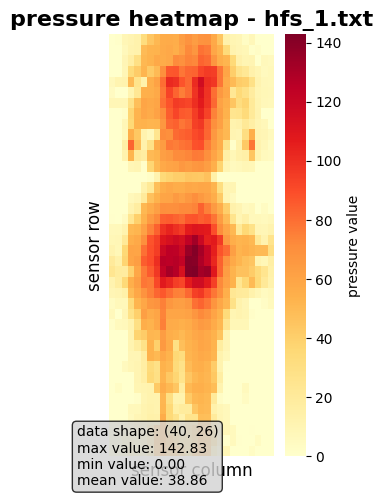


3. 进行睡姿预测...
预测完成！
预测结果: Supine
置信度: 0.966

4. 显示预测结果...


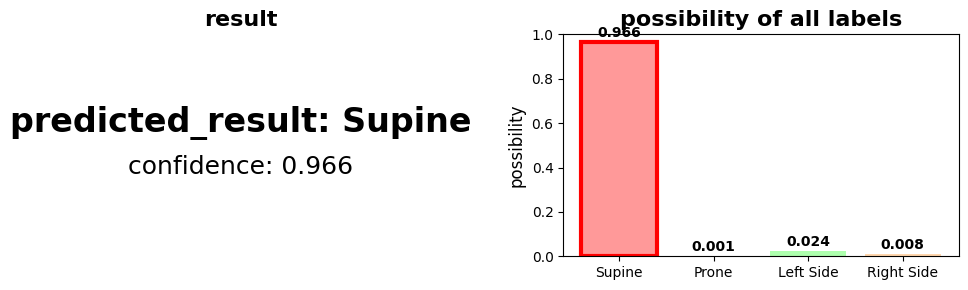


5. 各类别详细概率:
  Supine: 0.9663 ← 预测结果
  Prone: 0.0011
  Left Side: 0.0241
  Right Side: 0.0085

分析完成！


In [74]:
# 在这里输入您要分析的文件路径
file_path = "/workspaces/codespaces-jupyter/project/data/0902数据/hfs0902/hfs_1.txt"

# 运行分析
analyze_pressure_file(file_path)

## 批量测试示例

如果您想测试多个文件，可以使用下面的代码：

正在分析文件: /workspaces/codespaces-jupyter/project/data/0902数据/hfs0902/hfs_1.txt
1. 加载压力数据...
原始数据形状: (480, 26)
将 (480, 26) 重塑为 (40, 26)，使用 12 帧的平均值
数据加载成功！最终形状: (40, 26)

2. 绘制压力分布热力图...


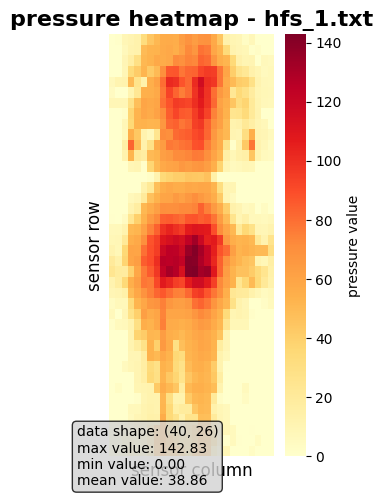


3. 进行睡姿预测...
预测完成！
预测结果: Supine
置信度: 0.966

4. 显示预测结果...


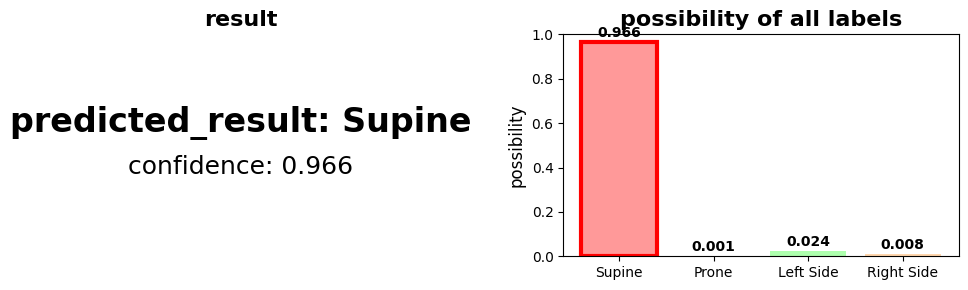


5. 各类别详细概率:
  Supine: 0.9663 ← 预测结果
  Prone: 0.0011
  Left Side: 0.0241
  Right Side: 0.0085

分析完成！


正在分析文件: /workspaces/codespaces-jupyter/project/data/0902数据/hfs0902/hfs_8.txt
1. 加载压力数据...
原始数据形状: (960, 26)
将 (960, 26) 重塑为 (40, 26)，使用 24 帧的平均值
数据加载成功！最终形状: (40, 26)

2. 绘制压力分布热力图...


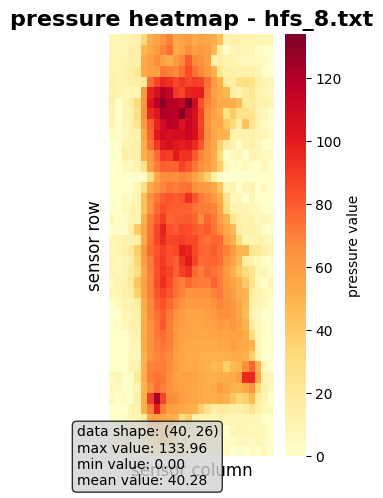


3. 进行睡姿预测...
预测完成！
预测结果: Prone
置信度: 0.963

4. 显示预测结果...


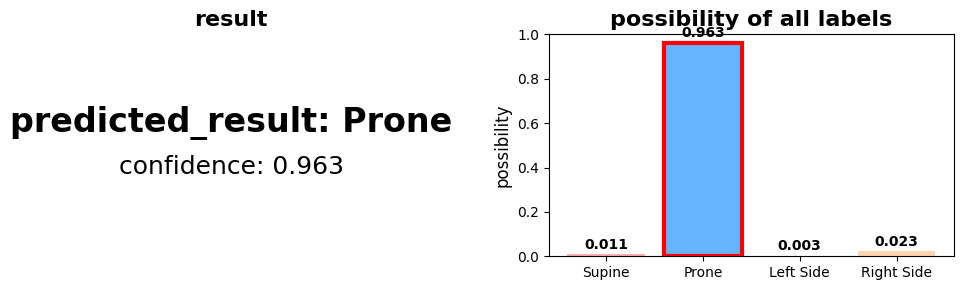


5. 各类别详细概率:
  Supine: 0.0107
  Prone: 0.9625 ← 预测结果
  Left Side: 0.0034
  Right Side: 0.0234

分析完成！


正在分析文件: /workspaces/codespaces-jupyter/project/data/0902数据/hfs0902/hfs_12.txt
1. 加载压力数据...
原始数据形状: (480, 26)
将 (480, 26) 重塑为 (40, 26)，使用 12 帧的平均值
数据加载成功！最终形状: (40, 26)

2. 绘制压力分布热力图...


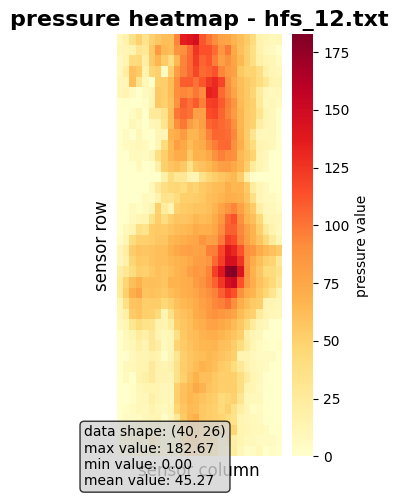


3. 进行睡姿预测...
预测完成！
预测结果: Left Side
置信度: 0.969

4. 显示预测结果...


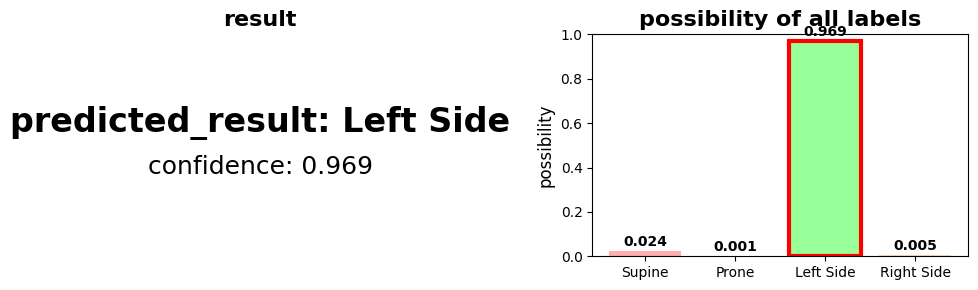


5. 各类别详细概率:
  Supine: 0.0244
  Prone: 0.0014
  Left Side: 0.9690 ← 预测结果
  Right Side: 0.0051

分析完成！


正在分析文件: /workspaces/codespaces-jupyter/project/data/0902数据/hfs0902/hfs_18.txt
1. 加载压力数据...
原始数据形状: (480, 26)
将 (480, 26) 重塑为 (40, 26)，使用 12 帧的平均值
数据加载成功！最终形状: (40, 26)

2. 绘制压力分布热力图...


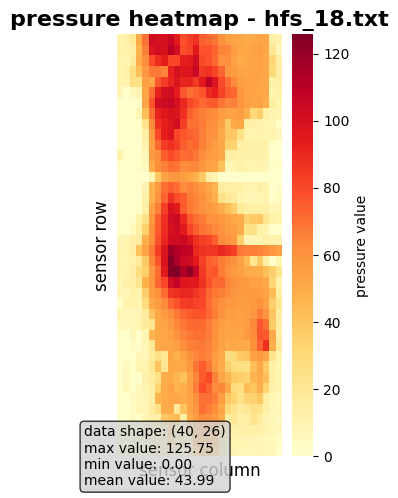


3. 进行睡姿预测...
预测完成！
预测结果: Right Side
置信度: 0.990

4. 显示预测结果...


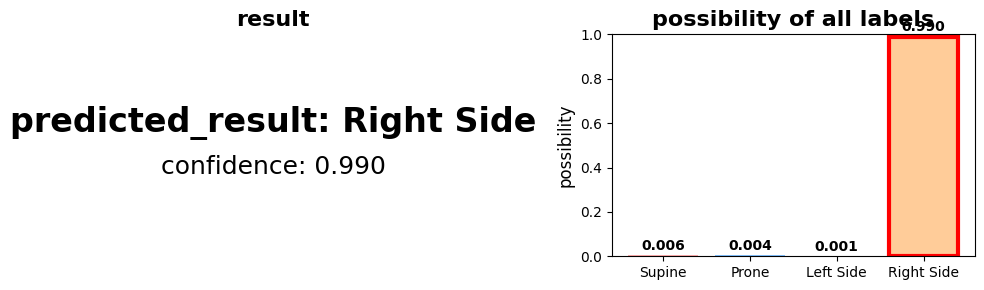


5. 各类别详细概率:
  Supine: 0.0058
  Prone: 0.0038
  Left Side: 0.0008
  Right Side: 0.9896 ← 预测结果

分析完成！




In [75]:
# 批量测试多个文件
test_files = [
    "/workspaces/codespaces-jupyter/project/data/0902数据/hfs0902/hfs_1.txt",   # 应该是仰卧
    "/workspaces/codespaces-jupyter/project/data/0902数据/hfs0902/hfs_8.txt",   # 应该是俯卧
    "/workspaces/codespaces-jupyter/project/data/0902数据/hfs0902/hfs_12.txt",  # 应该是左侧卧
    "/workspaces/codespaces-jupyter/project/data/0902数据/hfs0902/hfs_18.txt",  # 应该是右侧卧
]

for file_path in test_files:
    if os.path.exists(file_path):
        analyze_pressure_file(file_path)
        print("\n" + "="*80 + "\n")
    else:
        print(f"文件不存在: {file_path}")

## 自定义文件路径输入

您也可以在运行时输入文件路径：

请输入要分析的文件路径:
(例如: /workspaces/codespaces-jupyter/project/data/0902数据/hfs0902/hfs_1.txt)
正在分析文件: /workspaces/codespaces-jupyter/project/data/text_data/rxy/rxy_1.txt
1. 加载压力数据...
原始数据形状: (240, 26)
将 (240, 26) 重塑为 (40, 26)，使用 6 帧的平均值
数据加载成功！最终形状: (40, 26)

2. 绘制压力分布热力图...
正在分析文件: /workspaces/codespaces-jupyter/project/data/text_data/rxy/rxy_1.txt
1. 加载压力数据...
原始数据形状: (240, 26)
将 (240, 26) 重塑为 (40, 26)，使用 6 帧的平均值
数据加载成功！最终形状: (40, 26)

2. 绘制压力分布热力图...


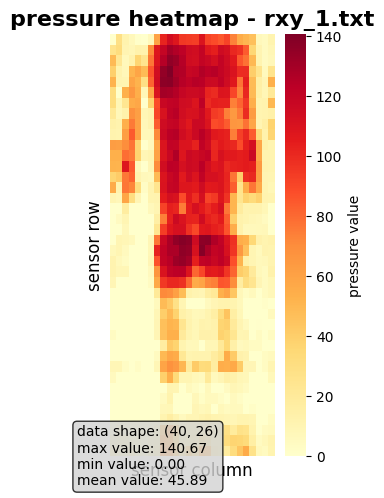


3. 进行睡姿预测...
预测完成！
预测结果: Supine
置信度: 1.000

4. 显示预测结果...


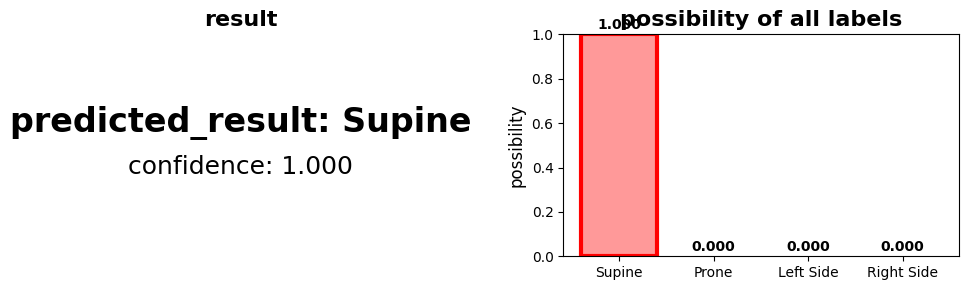


5. 各类别详细概率:
  Supine: 0.9999 ← 预测结果
  Prone: 0.0000
  Left Side: 0.0000
  Right Side: 0.0000

分析完成！


In [76]:
# 交互式输入文件路径
print("请输入要分析的文件路径:")
print("(例如: /workspaces/codespaces-jupyter/project/data/0902数据/hfs0902/hfs_1.txt)")

# 在Jupyter中，您可以直接修改下面的路径
custom_file_path = input("文件路径: ")

if custom_file_path.strip():
    analyze_pressure_file(custom_file_path.strip())
else:
    print("未输入文件路径")